# Сборный проект - 2

**Дополнительная информация:**

Файл с данными: /datasets/logs_exp.csv

**Цель исследования:**

- Разобраться, как ведут себя пользователи мобильного приложения (продажа продуктов питания).

- Изучим воронку продаж. Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

- Исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.

- Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, мы можем быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также поможет понять, сколько времени и данных потребуется для дальнейших тестов.

**Ход исследования:**

1. Откроем файл с данными и изучим общую информацию.

2. Подготовим данные.

3. Изучим и проверим данные:
- Сколько всего событий в логе?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Данными за какой период мы располагаем? Найдем максимальную и минимальную дату. Построим гистограмму по дате и времени. Определим, с какого момента данные полные и отбросьте более старые.
- Посмотрим, сколько событий и пользователей мы потеряли, отбросив старые данные?
- Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

4. Изучите воронку событий:
- Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем  события по частоте.
- Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.
- Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку?
- По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.
- На каком шаге теряете больше всего пользователей?
- Какая доля пользователей доходит от первого события до оплаты?

5. Изучите результаты эксперимента:
- Сколько пользователей в каждой экспериментальной группе?
- Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.
- Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. Проделаем то же самое для всех других событий.
- Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой. Сделаем выводы.

## Шаг 1. Открыаем файл с данными и изучаем общую информацию

In [1]:
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import plotly.express as px
from plotly import graph_objects as go
from scipy import stats as st
import math as mth

In [2]:
try:
    df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    df = pd.read_csv('/content/logs_exp.csv', sep='\t')

In [3]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


- Датасет состоит из 4 колонок и 244126 строк.
- Заменим названия столбцов.
- Заменим названия групп в столбце group на A1, A2 и B.
- Пропусков в данных нет.
- Поменяем тип переменной в столбце EventTimestamp на дату.
- Добавим столбец даты и времени, а также столбец дат.
- Проверим на дубликаты.

## Шаг 2. Подготавливаем данные

In [5]:
# заменим названия столбцов
df.rename(columns = {
    'EventName' : 'event_name',
    'DeviceIDHash' : 'user_id',
    'EventTimestamp' : 'event_time',
    'ExpId' : 'group'}, inplace = True)

In [6]:
df.head()

,event_name,user_id,event_time,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [7]:
# поменяем тип переменной в столбце EventTimestamp на дату
df['event_time'] = pd.to_datetime(df['event_time'], unit='s')
df.head()

,event_name,user_id,event_time,group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


In [8]:
# добавим столбец дат
df['date'] = df['event_time'].dt.date
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   user_id     244126 non-null  int64         
 2   event_time  244126 non-null  datetime64[ns]
 3   group       244126 non-null  int64         
 4   date        244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


In [9]:
# для удобства переименуем группы
df['group'] = df['group'].astype('object')
mapping = {246:'A1',247:'A2',248:'B'}
df['group'] = df['group'].map(mapping)
df.head()

,event_name,user_id,event_time,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,A1,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,A1,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,B,2019-07-25


In [10]:
# проверяем на дубликаты
df.duplicated().sum()

413

In [11]:
df[df.duplicated(keep=False)].head()

,event_name,user_id,event_time,group,date
452,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,B,2019-07-30
453,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,B,2019-07-30
2348,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,B,2019-07-31
2350,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,B,2019-07-31
3572,MainScreenAppear,434103746454591587,2019-08-01 02:59:37,B,2019-08-01


In [12]:
# удаляем дубликаты
df = df.drop_duplicates().reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   event_time  243713 non-null  datetime64[ns]
 3   group       243713 non-null  object        
 4   date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 9.3+ MB


In [13]:
df['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

In [14]:
df['group'].value_counts()

B     85582
A1    80181
A2    77950
Name: group, dtype: int64

In [15]:
df.head()

,event_name,user_id,event_time,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,A1,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,A1,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,B,2019-07-25


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   event_time  243713 non-null  datetime64[ns]
 3   group       243713 non-null  object        
 4   date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 9.3+ MB


Проверим, не попали ли у нас одни и те же пользователи в разные группы

In [17]:
len(np.intersect1d(df.query('group == "A1"')['user_id'].unique(), df.query('group == "A2"')['user_id'].unique()))

0

In [18]:
len(np.intersect1d(df.query('group == "A1"')['user_id'].unique(), df.query('group == "B"')['user_id'].unique()))

0

In [19]:
len(np.intersect1d(df.query('group == "A2"')['user_id'].unique(), df.query('group == "B"')['user_id'].unique()))

0

Таких пользователей нет.

## Шаг 3. Изучаем и проверяем данные

- Сколько всего событий в логе?

In [20]:
events = len(df)
'Всего событий в логе: {}'.format(events)

'Всего событий в логе: 243713'

- Сколько всего пользователей в логе?

In [21]:
users = df['user_id'].nunique()
'Всего уникальных пользователей в логе: {}'.format(users)

'Всего уникальных пользователей в логе: 7551'

- Сколько в среднем событий приходится на пользователя?

In [22]:
event_mean = df.groupby('user_id').agg({'event_name':'count'}).reset_index().sort_values(by='event_name', ascending=False)
event_mean.columns = ['user_id', 'count']
event_mean

,user_id,count
5116,6304868067479728361,2307
147,197027893265565660,1998
3714,4623191541214045580,1768
5590,6932517045703054087,1439
1391,1754140665440434215,1221
...,...,...
6013,7399061063341528729,1
2356,2968164493349205501,1
6575,8071397669512236988,1
311,425817683219936619,1


In [23]:
event_mean.describe()

,user_id,count
count,7.551000e+03,7551.000000
mean,4.677319e+18,32.275593
std,2.655343e+18,65.154219
min,6.888747e+15,1.000000
25%,2.397700e+18,9.000000
50%,4.688022e+18,20.000000
75%,7.007353e+18,37.000000
max,9.222603e+18,2307.000000


- В среднем на пользователя приходится 32 события.
- Медиана равна 20.

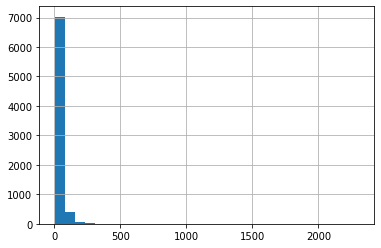

In [24]:
event_mean['count'].hist(bins=30);

In [ ]:
event_mean['count'].hist(bins=30, range=(0,500));

In [ ]:
event_mean['count'].hist(bins=30, range=(0,150));

Гистограмма говорит нам о том, что большинство пользователей совершают до 30 событий.

- Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?

In [ ]:
# узнаем минимальную и максимальную дату
'Минимальная дата: {}'.format(df['event_time'].min())

In [ ]:
'Максимальная дата: {}'.format(df['event_time'].max())

In [ ]:
df_group = df.groupby('date').agg({'event_time':'count'}).reset_index()
df_group

In [ ]:
df_group.plot(x='date', y='event_time', kind='bar', figsize = (15,5));

In [ ]:
# код ревьюера
df['event_time'].hist(bins=14*24, figsize=(14, 5));

По гистограмме видно, что полные данные у нас за период с 01.08.2019 по 07.08.2019. Этот период и будем считать актуальным для анализа.

In [ ]:
# удаляем неактувальные данные
df_new = df.loc[df['date'] > '2019-07-31']
df_new.head()

- Много ли событий и пользователей вы потеряли, отбросив старые данные?

In [ ]:
'Событий до очистки: {}'.format(len(df))

In [ ]:
'Событий после очистки: {}'.format(len(df_new))

In [ ]:
'Потеря ~ {} % событий'.format((len(df)-len(df_new))/len(df))

In [ ]:
'Пользователей до очистки: {}'.format(users)

In [ ]:
users_new = df_new['user_id'].nunique()
'Пользователей после очистки: {}'.format(users_new)

In [ ]:
'Потеря ~ {} % событий'.format((users-users_new)/users)

- Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

In [ ]:
df['group'].value_counts()

In [ ]:
df.groupby('group')['user_id'].nunique()

Мы изучили данные и можем сделать вывод:
- Всего в логе 243713 событий.
- Всего в логе 7551 пользователь.
- В среднем на пользователя приходится примерно 32 события.
- Актуальный период для анализа с 01.08.2019 по 07.08.2019.
- Отбросив старые данные мы потеряли около 1% пользователей и событий.
- Отбросив старые данные, у нас остались пользователи всех трех экспериментальных групп.

## Шаг 4. Изучаем воронку событий

- Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

In [ ]:
df_new['event_name'].value_counts().sort_values(ascending=False)

- MainScreenAppear - появление главного экрана
- OffersScreenAppear - появление экрана с предложением товара
- CartScreenAppear - переход в корзину
- PaymentScreenSuccessful - экран с успешной оплатой
- Tutorial - руководство пользователя

- Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [ ]:
users_count = df_new.groupby('event_name').agg({'user_id':'nunique'}).reset_index().sort_values(by='user_id')
users_count.columns = ['event_name', 'user_count']
users_count['ratio'] = round((users_count['user_count']/users_new*100), 1)
users_count

In [ ]:
fig = px.bar(users_count, x='ratio', y='event_name', text='ratio')

fig.update_layout(
    title='Доля пользователей, которые хоть раз совершали событие',
    xaxis_title='Доля пользователей',
    yaxis_title='Событие'
)

fig.show()

- 98,5% пользователей заходили на главный экран.
- 61% пользователей заходили на страницу с предложением.
- 49.6% пользователей преходили в корзину.
- 47% пользователей производили успешную оплату.
- 11.1% пользователей знакомились с руководством.

- Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

События происходят в следующей последовательности:
1. Пользователь зашел на главную страницу.
2. Пользователю предлагается ознакомиться с руководством.
3. Пользователь заходит на страницу с предложением.
4. Пользователь переходит в корзину.
5. Пользователь оплачивает товар.

Т.к. этап Tutorial пользователи чаще всего пропускают, удалим это событие из воронки.

In [ ]:
df_new = df_new.query('event_name!="Tutorial"').reset_index()
df_new.head()

- По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [ ]:
users_count = users_count.query('event_name!="Tutorial"').sort_values(by='user_count', ascending=False)
users_count

In [ ]:
users_count['funnel'] = (users_count['user_count'].div(users_count['user_count'].shift(1)).fillna(1)).round(2)
users_count

In [ ]:
# построим воронку
fig = go.Figure(go.Funnel(
    y = users_count['event_name'],
    x = users_count['user_count'], 
    textinfo = 'value+percent previous'))
fig.update_layout(title='Число и доля пользователей совершавших событытие', title_x = 0.5)
fig.show()

- На каком шаге теряете больше всего пользователей?

Больше всего пользователей (38%) теряется на этапе перехода с главного экрана на страницу с предложением.

- Какая доля пользователей доходит от первого события до оплаты?

In [ ]:
users_count

47% пользователей доходят от первого события до оплаты.

## Шаг 5. Изучите результаты эксперимента

- Сколько пользователей в каждой экспериментальной группе?

In [ ]:
users_group = df_new.groupby('group')['user_id'].nunique()
users_group['A1+A2'] = users_group['A1'] + users_group['A2']
users_group

- В группе A1 - 2483 пользователей.
- В группе A2 - 2512 пользователей.
- В группе B - 2535 пользователей.

- Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.
- Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?
- Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

Критерии успешного A/A-теста:
- Количество пользователей в различных группах различается не более, чем на 1%;
- Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
- Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.

In [ ]:
((1 - users_group['A1']/users_group['A2'])*100).round(2)

In [ ]:
# для проведения теста создадим сводную таблицу
event_group = df_new.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique').sort_values(by='A1', ascending=False).reset_index()
event_group['A1+A2'] = event_group['A1'] + event_group['A2']
event_group['all'] = event_group['A1'] + event_group['A2'] + event_group['B']
event_group['part_A1'] = (event_group['A1'] / users_group['A1'] * 100).round(2)
event_group['part_A2'] = (event_group['A2'] / users_group['A2'] * 100).round(2)
event_group['part_B'] = (event_group['B'] / users_group['B'] * 100).round(2)
event_group['part_A1+A2'] = ((event_group['A1']+event_group['A2']) / (users_group['A1+A2']) * 100).round(2)
event_group

- Разбивка на группы довольно равномерная, и можно считать ее корректной.

In [ ]:
df['event_name'].value_counts()

- Самое популярное событие - MainScreenAppear.
- Всего 7419 пользователей совершили событие MainScreenAppear.
- Из них:
- 2450 из группы А1.
- 2476 из группы А2.
- 2493 из группы В.
- Доли пользователей, совершивших событие MainScreenAppear:
- 98.67% группа А1.
- 98.57% группа А2.
- 98.34% группа В.

Напишем функцию z_test для проведения тестов, на вход подаются 3 параметра: group1, group2, alpha(уровень статистической значимости):

Сформулируем гипотезы:

- H0: Доли уникальных посетителей, побывавших на этапе воронки, одинаковы.
- H1: Между долями уникальных посетителей, побывавших на этапе воронки, есть значимая разница.

In [ ]:
def z_test(group1, group2, alpha):
    for i in event_group.index:
        p1 = event_group[group1][i] / users_group[group1]
        # пропорция успехов во второй группе:
        p2 = event_group[group2][i] / users_group[group2]
        # пропорция успехов в комбинированном датасете:
        p_combined = ((event_group[group1][i] + event_group[group2][i]) / 
                      (users_group[group1] + users_group[group2]))
        # разница пропорций в датасетах
        difference = p1 - p2
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/users_group[group1] + 1/users_group[group2]))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('{} p-значение: {}'.format(event_group['event_name'][i], p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')

Степень различия ключевых метрик по группам зависит от необходимой чувствительности эксперимента. Если мы хотим определить результаты теста, в котором ожидаем не менее 30% прироста, то 10% погрешности измерений нас устроят. Однако такое бывает редко: изменение показателей на 30% обычно заметно и без A/B-теста. Его применяют там, где степень различия между группами не больше 10%, или же подвержены колебаниям. В таких случаях точность A/A-теста в 1% — распространённый критерий.

In [ ]:
z_test('A1', 'A2', 0.01)

По результатам A1/A2 тестирования для всех событий разница не оказалось значимой, поэтому эти группы считаем контрольными. Так как для A/B теста не нужна высокая точность, то для дальнейших экспериментов выберем самый стандартный уровень значимости равный 5%. Дальше проведем еще 3 группы тестов: A1/B , A2/B , A1+A2/B:

In [ ]:
z_test('A1', 'B', 0.05)

In [ ]:
z_test('A2', 'B', 0.05)

In [ ]:
z_test('A1+A2', 'B', 0.05)

Значимой разницы между группами во всех тестах не выявлено. Вывод о различии долей сделать нельзя. Изменение шрифта никак не повлияло на пользователей.

## Вывод:

Были загружены и подготовлены к анализу данные:

- Заменили названия столбцов.
- Заменили названия групп в столбце group на A1, A2 и B.
- Пропусков в данных не обнаружено.
- Поменяли тип переменной в столбце EventTimestamp на дату.
- Добавили столбец даты и времени, а также столбец дат.
- Удалили явные дубликаты.

В ходе анализа было выявлено:

- Всего в логе 243713 событий.
- Всего в логе 7551 пользователь.
- В среднем на пользователя приходится примерно 32 события.
- Актуальный период для анализа с 01.08.2019 по 07.08.2019.
- Отбросив старые данные мы потеряли около 1% пользователей и событий.
- Отбросив старые данные, у нас остались пользователи всех трех экспериментальных групп.

Изучили воронку событий:

События происходят в следующей последовательности:

1. Пользователь зашел на главную страницу.
2. Пользователю предлагается ознакомиться с руководством.
3. Пользователь заходит на страницу с предложением.
4. Пользователь переходит в корзину.
5. Пользователь оплачивает товар.

Доли пользователей, которые хоть раз совершали событие, выглядят так:

- 98,5% пользователей заходили на главный экран.
- 61% пользователей заходили на страницу с предложением.
- 49.6% пользователей преходили в корзину.
- 47% пользователей производили успешную оплату.
- 11.1% пользователей знакомились с руководством.

Выяснили, что больше всего пользователей (38%) теряется на этапе перехода с главного экрана на страницу с предложением и 47% пользователей доходят от первого события до оплаты.



Группы для А/А/В-тестирования были достаточно хорошо сформированы, хоть и между группами А1 и А2 количество пользователей отличается на 1.15 % при рекомендованных 0.5-1%

По результатам А/А/В-теста не было выявлено различий между контрольными и эксперементальной группами, что говорит о том, что замена шрифтов никак не повлияла на пользователей ни в худшую, ни в лучшую сторону.